# Popular or Unpopular - Online News Article Popularity Prediction

**Team Name**: 4Twos

**Name and NetID of Each Team Member:** 
    1. Nhung Le - nhl256
    2. Hengyu Tang -ht1162
    3. Shirley Xu - xx852
    4. Shradha Taneja - st3277

# 1. Executive Summary

Aim to have 3 main findings

# 2. Problem Formulation and Motivation

## 2.1. Business Goals: 

Given fast technology advancement and an increasing popularity of smart phones and gadgets, we have seen an increasing demand for online news, thus the capability to predict popularity of the articles published online. We believe that such business problem is worth investigating since it will help publishers and editors maximize marketing reaches and cater future articles to readers’ preferences, while enabling companies to increase profits from advertisements if applicable. To be more precise, the result of this project could be adopted by companies to predict the popularity of each article prior to its publication. It can inform businesses on how to write a popular article in great detail, including channel, keywords, title subjectivity, title polarity, time of publication, number of images to present, number of links to include, etc. 

## 2.2. Data Science Goals: 

We formed the following data science goals to achieve such interesting business goals: 

1. To build a binary classification (unpopular, popular) model to predict popularity of news article.
2. To develop a multinomial classification with 3 levels of popularity (low, medium, high).
3. To explore the data visualization and real-time model evaluations to look for interesting patterns which might play some role in the target prediction.
4. To build a descriptive model that provides insights on current customers’ preferences, hence to better select articles accordingly to increase number of views
5. To conduct a regression model on predicting the exact number of shares for each article.


# 3. Baseline Model 

**Nhung:** I will work on variables so our data is runnable for a very baseline model to set the benchmark 

In [2]:
# Importing packages
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer

import statsmodels.api as sm
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn import model_selection

In [3]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score

In [6]:
#import xgboost
#import metrics 
import os
import time
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [7]:
raw_data = pd.read_csv('OnlineNewsPopularity.csv')

FileNotFoundError: File b'OnlineNewsPopularity.csv' does not exist

In [4]:
raw_data.columns = raw_data.columns.str.strip()

In [5]:
data = raw_data

In [6]:
# Verify if all columns are numerical 
object_col = data.select_dtypes(include='object')
num_col = list(data.select_dtypes(include='int64').columns)
#object_col.drop('Type', axis = 1)
object_col = list(object_col.columns)
print(object_col)
#print(num_col)

['url']


** Note ** 'url is the ony objective column, so we need to encode it first

In [7]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from numpy import array

In [8]:
#Label Encode object variables
for col in object_col: 
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(list(data[col].values))

In [9]:
object_col = data.select_dtypes(include='object')
object_col = list(object_col.columns)
print('Number of object columns after encoding is: {}'.format(len(object_col)))

Number of object columns after encoding is: 0


## 3.1. Exploring targeted variable

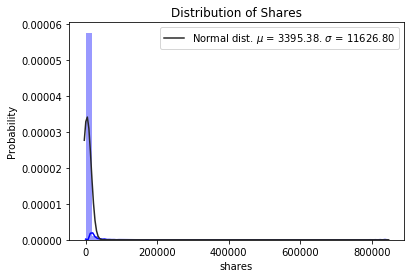

In [10]:
y = (data['shares'])
(mu, sigma) = norm.fit(y)
sns.distplot(y, fit = norm, norm_hist = True, color = 'B')
plt.legend(['Normal dist. $\mu$ = {:.2f}. $\sigma$ = {:.2f}'.format(mu, sigma)])
plt.ylabel('Probability')
plt.title('Distribution of Shares')
plt.show()

In [11]:
#Statistics of column shares
data.describe().iloc[:, -1]

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

** Note **: Using the distribution plot and looking at statistics of the 'shares' column, we can see that the number of shares do not follow a normal distribution and there are a very long long tail. This means although on average, articles receive around 3,400 shares, there is a large range of number of shares from 1 to 843,300. 

Thus, we decided to log transform number of shares before running a regression.

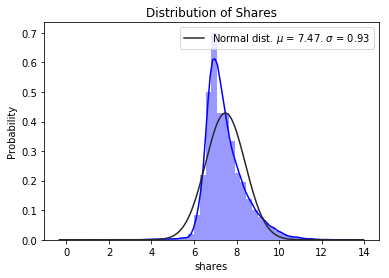

In [11]:
y = np.log(data['shares'])
(mu, sigma) = norm.fit(y)
sns.distplot(y, fit = norm, norm_hist = True, color = 'B')
plt.legend(['Normal dist. $\mu$ = {:.2f}. $\sigma$ = {:.2f}'.format(mu, sigma)])
plt.ylabel('Probability')
plt.title('Distribution of Shares')
plt.show()

** Note**: Although the number of shares are not fully normally distributed, log transforming the shares reduce the huge gaps of shares between articles, and we can start predicting number of shares using regression.

## 3.2. Root mean square error

This metric represents the sample standard deviation of the difference between predicted values and observed values (called residuals) 

In [10]:
#Def fine rmsq function
def rmse(log_y_pred, log_y_true): 
    return np.sqrt((np.average((log_y_pred - log_y_true)**2)))

In [11]:
def ValRMSE_base(X_train, Y_train, model, k): 
    kf = KFold(n_splits = k)
    scores = []
    train_scores = []
    for cv_train, cv_validate in kf.split(X_train): 
        X_cv_train = X_train.iloc[cv_train]
        X_cv_validate = X_train.iloc[cv_validate]
        
        Y_cv_train = Y_train.iloc[cv_train]
        log_y_cv_train = np.log(Y_cv_train)
        
        Y_cv_validate = Y_train.iloc[cv_validate]
        log_y_cv_validate = np.log(Y_cv_validate)
        model.fit(X_cv_train, log_y_cv_train)
        log_y_pred = model.predict(X_cv_validate)
        scores.append(rmse(log_y_pred, log_y_cv_validate))
        
        log_y_train_pred = model.predict(X_cv_train)
        train_scores.append(rmse(log_y_cv_train, log_y_train_pred))
    return (np.array(scores), np.array(train_scores))

In [12]:
X_train_base = data.drop('shares', axis = 1)
Y_train_base = data['shares']

## 3.3. Regression 


### 3.3.1. Multiple linear regression

In [16]:
Multiple_linear = LinearRegression()
scores, train_scores = ValRMSE_base(X_train_base, Y_train_base, Multiple_linear, 5)
print("\nMultiple Linear score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nMultiple Linear train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))

/Users/NhungLe/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)



Multiple Linear score: 1.0816 (0.3512)


Multiple Linear train score: 0.8676 (0.0119)



### 3.3.2. Lasso

In [15]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.005, random_state=1))
scores, train_scores = ValRMSE_base(X_train_base, Y_train_base, lasso, 5)
print("\nLasso score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nLasso train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))

/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Lasso score: 0.9123 (0.0787)


Lasso train score: 0.8708 (0.0121)



/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


** Note **: For both linear regression and the Lasso regression, Root Mean Squared Error score of in-sample data is much better than score of out-sample data, indicating overfitting. However, the RMSE of the test set are still high (1.086 and 0.912 for linear regression and the Lasso regression respectively). This means there is room for improvement if we engineer features and select a better model. 

### 3.3.3. Ridge Regression

In [14]:
# KRR = KernelRidge(alpha=3, kernel='polynomial', degree=2, coef0=2.5)
# scores, train_scores = ValRMSE_base(X_train_base, Y_train_base, KRR, 5)
# print("\nKernel Ridge score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
# print("\nKernel Ridge train score: {:.4f} ({:.4f})\n".format(
#     train_scores.mean(), train_scores.std()))

## 3.4. Binary Classification

We will use the threshold of 1400 shares as the threshold for popularity (i.e., if the number of shares >= 1400 then it is popular, else it is not popular

In [14]:
base_data = data.copy()
base_data['popular'] = 1
base_data.loc[data['shares'] < 1400, 'popular'] = 0
X_train_base = base_data.drop(['shares', 'popular'], axis = 1)
Y_train_base = base_data['popular']

In [15]:
from sklearn.metrics import roc_auc_score
def AUCScore_base(X_train, Y_train, model, k): 
    kf = KFold(n_splits = k)
    scores = []
    train_scores = []
    for cv_train, cv_validate in kf.split(X_train): 
        X_cv_train = X_train.iloc[cv_train]
        X_cv_validate = X_train.iloc[cv_validate]
        Y_cv_train = Y_train.iloc[cv_train]
        Y_cv_validate = Y_train.iloc[cv_validate]
        
        model.fit(X_cv_train, Y_cv_train)
        Y_validate_pred = model.predict_proba(X_cv_validate)[:, 1]
        Y_train_pred = model.predict_proba(X_cv_train)[:, 1]
        
        scores.append(roc_auc_score(Y_cv_validate, Y_validate_pred))
        train_scores.append(roc_auc_score(Y_cv_train, Y_train_pred))
    return (np.array(scores), np.array(train_scores))

In [16]:
logreg = LogisticRegression(solver = 'lbfgs')
scores, train_scores = AUCScore_base(X_train_base, Y_train_base, logreg, 5)
print("\nLogistic Regression score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nLogistic Regression train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Logistic Regression score: 0.6073 (0.0344)


Logistic Regression train score: 0.6244 (0.0044)



# 4. Regression

In [17]:
X = data.drop('shares', axis = 1)
Y = data['shares']

In [18]:
def rmse_cal(model, X_train, Y_train, X_test, Y_test): 
    log_y_train = np.log(Y_train)
    log_y_test = np.log(Y_test)
    model.fit(X_train, log_y_train)
    log_y_pred = model.predict(X_test)
    return(rmse(log_y_test, log_y_pred))

## 4.1. Lasso Tuning Parameter

In [23]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

In [27]:
alpha_lasso = [i for i in frange(0.05, 0.15, 0.01)]

In [29]:
#alpha_lasso

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
rmse_lasso = {}
for alpha in alpha_lasso:
    rmse_alpha = []
    for num_fold in range(10): 
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
        model = make_pipeline(RobustScaler(), Lasso(alpha=alpha, random_state=1))
        rmse_alpha.append(rmse_cal(model, X_train, Y_train, X_test, Y_test))
    rmse_lasso[alpha] = rmse_alpha

In [33]:
#rmse_lasso

In [34]:
mse_avg = {alpha: np.average([i**2 for i in rmse_lasso[alpha]]) for alpha in alpha_lasso }

In [35]:
mse_avg

{0.05: 1.8851629500290692,
 0.060000000000000005: 1.2417640133601335,
 0.07: 0.93557651568510158,
 0.08: 0.94995575329395765,
 0.09: 1.594282100802215,
 0.09999999999999999: 1.4697068803925391,
 0.10999999999999999: 1.1550149191291379,
 0.11999999999999998: 1.1054334534159465,
 0.12999999999999998: 1.7213042545967574,
 0.13999999999999999: 1.3205202664078406}

In [44]:
x_axis = list(mse_avg.keys())

In [45]:
y_axis = list(mse_avg.values())

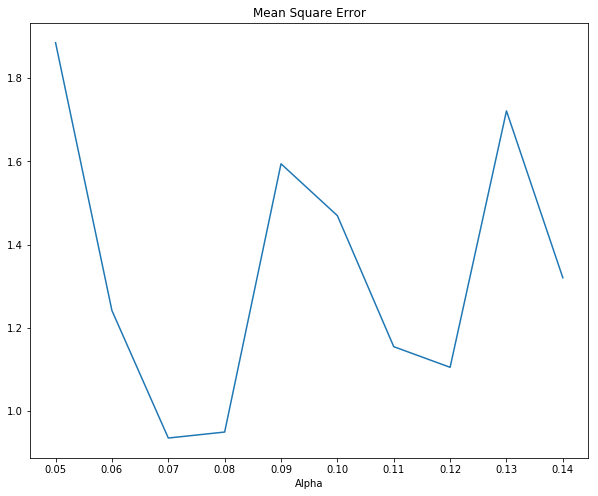

In [46]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
plt.plot(x_axis, y_axis, label = 'Alpha = {}'.format(alpha))
#ax.legend(loc = 'upper center', bbox_to_anchor = (1.5, 1),
#        fancybox = True, shadow = True, ncol = 1, prop = {'size': 15})
plt.title('Mean Square Error')
plt.xlabel('Alpha')
plt.xticks(np.arange(min(x_axis), max(x_axis)+0.01, 0.01))
plt.show()

Best alpha is 0.07

In [52]:
#RMSE for Lasso at alpha 0.07
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.07, random_state=1))
scores, train_scores = ValRMSE_base(X, Y, lasso, 10)
print("\nLasso score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nLasso train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


Lasso score: 1.0322 (0.3811)


Lasso train score: 0.8991 (0.0064)



## 4.2. XGBoost

In [48]:
import xgboost

/Users/NhungLe/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [49]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [50]:
scores, train_scores = ValRMSE_base(X, Y, xgb, 5)
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))
print("\nXGBoost train score: {:.4f} ({:.4f})\n".format(
    train_scores.mean(), train_scores.std()))


XGBoost score: 0.8924 (0.0789)


XGBoost train score: 0.7063 (0.0073)



## 4.3. PCA

Given 61 features, we would like to apply Principle Component Analysis to reduce dimension of the data. What PCA does is to project our original data of 61-dimensional subspace to a lower k-dimensional subspace to reserve as much variances as possible. The goal is to select a bucket of features that capture the most information about the dataset.  

In [76]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [91]:
n_components = [i for i in range(1, 61)]
#n_components
pca_var = []
for i in n_components: 
    pca = PCA(n_components = i)
    pca.fit(X)
    var = np.cumsum((pca.explained_variance_ratio_)*100) 
    pca_var.append(var[-1])

In [82]:
pca_var

[65.111895941740443,
 75.205943019373208,
 83.639665199790514,
 89.520089907683314,
 94.088096599970442,
 97.225082562613309,
 99.017220507887615,
 99.752785673363277]

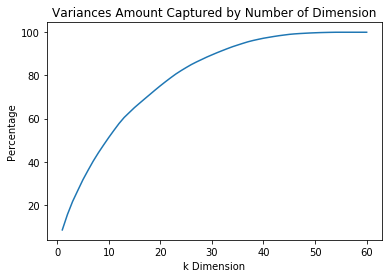

In [92]:
fig = plt.figure()
plt.plot(n_components, pca_var)
plt.title('Variances Amount Captured by Number of Dimension')
plt.ylabel('Percentage')
plt.xlabel('k Dimension')
plt.show()

In [83]:
#var = np.cumsum((pca.explained_variance_ratio_)*100) 
#var[]

** Note **: The var is an array showing cummulative sum of information captured by the features used. For example, the first feature, which captures the most information of the number of shares, explains 8.5% of the variance within out dataset. The first two features capture 15.6% of the variance within our dataset. 30 features can capture 90% of all variance within our dataset. 

In [65]:
def rmse_cal(model, X_train, Y_train, X_test, Y_test): 
    log_y_train = np.log(Y_train)
    log_y_test = np.log(Y_test)
    model.fit(X_train, log_y_train)
    log_y_pred = model.predict(X_test)
    return(rmse(log_y_test, log_y_pred))

In [66]:
def cv_rmse(model, pca_flag, X, Y, num_fold, alpha):
    cv_rmse = []
    for i in range(num_fold):
        X_train, X_test, Y_train, Y_test = train_test_split(
                    X, Y, test_size = 0.33)
        if pca_flag == True: 
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        if model == 'Lasso':
            model = make_pipeline(RobustScaler(), Lasso(alpha=alpha, random_state=1))
        elif model == 'XGB':
            model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)    
        cv_rmse.append(rmse_cal(model, X_train, Y_train, X_test, Y_test))
    return cv_rmse

In [75]:
#XGB_rmse_score = cv_rmse('XGB', True, X, Y, 10, alpha)
#print("\nXGBoost score: {:.4f} ({:.4f})\n".format(np.mean(cv_rmse_score), np.std(cv_rmse_score)))

In [70]:
np.mean(XGB_rmse_score)

0.87427060215810037

In [71]:
np.std(XGB_rmse_score)

0.0039772548669619922

In [74]:
Lasso_rmse_score = cv_rmse('Lasso', True, X, Y, 10, 0.07)
print("\nLasso score: {:.4f} ({:.4f})\n".format(np.mean(Lasso_rmse_score), np.std(Lasso_rmse_score)))


Lasso score: 0.9244 (0.0083)

